In [118]:
%load_ext autoreload
%autoreload 2

from multiprocessing import Pool
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import networkx
from loguru import logger
from tqdm.notebook import tqdm

from pim.models.network import Network
from pim.models.new.stone import StoneExperiment, StoneResults
from pim.models.new.stone.rate import CXRatePontin, CPU4PontinLayer

from pim.models.stone import analysis

logger.remove()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


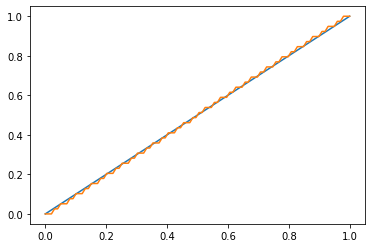

In [2]:
N = 40
bins = np.linspace(1/N, 1, N-1, endpoint=False)

def q(I):
    return np.digitize(I, bins) / (N-1)

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.plot(np.linspace(0, 1, 100), q(np.linspace(0, 1, 100)))

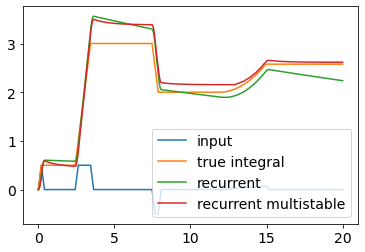

In [166]:
K = 1.0
gain = 0.98

def dydtq(I, y):
    return (q(I) - y) * K

def dydti(I, y):
    return (I - y) * K

def step(x, y, dydt, dt):
    I = x + y * gain
    return y + dt * dydt(I, y)

t0=0
tf=20
r=100
t = np.linspace(t0, tf, r)

x = np.zeros(t.size)
x[(0.2 < t) & (t < 0.3)] = 1.0
x[(2.5 < t) & (t < 3.5)] = 1.0
x[(7.5 < t) & (t < 8)] = -1.0
x[(12 < t) & (t < 15)] = (t[(12 < t) & (t < 15)]-12)*0.05
x *= 0.5
z = np.cumsum(x)
x = interp1d(t, x)
z = interp1d(t, z)

plt.plot(t, x(t), label="input")
plt.plot(t, z(t), label="true integral")

dt = 0.001
T = t0
y = [0]
y2 = [0]
t = [T]
while T < tf:
    y.append(step(x(T), y[-1], dydtq, dt))
    y2.append(step(x(T), y2[-1], dydti, dt))
    T += dt
    t.append(T)
    
plt.plot(t, np.array(y2)*6, label="recurrent")

plt.plot(t, np.array(y)*6, label="recurrent multistable")
plt.legend()

In [209]:
def create_quantized_layer(N):
    def closure(*args, **kwargs):
        return SoftQuantizedCPU4PontinLayer(N, *args, **kwargs)
    return closure

class SoftQuantizedCPU4PontinLayer(CPU4PontinLayer):
    def __init__(self, N, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.gain *= 1
        self.N = N
        self.K = 1
        self.subdt = 0.005
        self.bins = np.linspace(1/self.N, 1, self.N-1, endpoint=False)
    
    def step(self, network: Network, dt: float):
        """Memory neurons update.
        cpu4[0-7] store optic flow peaking at left 45 deg
        cpu[8-15] store optic flow peaking at right 45 deg."""
        tb1 = network.output(self.TB1)
        tn1 = network.output(self.TN1)
        tn2 = network.output(self.TN2)

        mem_update = np.dot(self.W_TN, tn2)
        mem_update -= np.dot(self.W_TB1, tb1)
        mem_update = np.clip(mem_update, 0, 1)
        mem_update = (mem_update - 0.125) * self.gain # input to each memory unit
        
        t = 0
        while t < dt:
            self.memory = self.substep(mem_update, self.memory, self.dydtq, self.subdt)
            t += self.subdt # needs to me small enough for accuracy
            
        self.memory = np.clip(self.memory, 0.0, 1.0)
    
    def q(self, I):
        return np.digitize(I, self.bins) / (self.N-1)

    def dydtq(self, I, y):
        #print(I, q(I))
        return (self.q(I) - y) * self.K

    def dydti(self, I, y):
        return (I - y) * self.K

    def substep(self, x, y, dydt, dt):
        I = x + y * 1.00 # feedback gain is not what we're interested in here
        return y + dt * dydt(I, y)
        
        #self.memory = np.clip((np.digitize(self.memory, self.bins) - 1) / self.N, 0.0, 1.0)

In [173]:
parameters = {
    "model": "stone",
    "T_outbound": 1500,
    "T_inbound": 1000,
    "time_subdivision": 1,
    "noise": 0.1,
    "cx": "pontin"
}

def create_experiment(cpu4):
    cx = CXRatePontin(CPU4LayerClass=cpu4, noise = parameters["noise"])
    cx.setup()
    experiment = StoneExperiment(parameters)
    experiment.cx = cx
    return experiment

def run_experiment(cpu4, ts = 1, report = False):
    experiment = create_experiment(cpu4)
    experiment.parameters["time_subdivision"] = ts
    results = experiment.run("test")
    if report:
        results.report()
    return np.linalg.norm(results.closest_position())


In [180]:
mean_benchmark = np.mean([run_experiment(CPU4PontinLayer) for i in tqdm(range(0, 10))])
print(f"Benchmark mean: {mean_benchmark}")

  0%|          | 0/10 [00:00<?, ?it/s]

Benchmark mean: 8.540850285520797


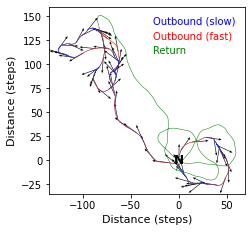

0.42083229250578374

In [215]:
run_experiment(create_quantized_layer(10000), report=True)

In [216]:
Ns = range(50, 10001, 50)

def task(N):
    return np.mean([run_experiment(create_quantized_layer(N)) for i in range(0, 10)])

with Pool(6) as p:
    results = list(tqdm(p.imap(task, Ns), total=len(Ns)))
    
px.scatter(x=Ns, y=results, labels={"x": "resolution", "y": "smallest distance from nest"})

  0%|          | 0/200 [00:00<?, ?it/s]

Process ForkPoolWorker-48:
Process ForkPoolWorker-47:
Process ForkPoolWorker-46:
Process ForkPoolWorker-45:
Process ForkPoolWorker-44:
Traceback (most recent call last):
Process ForkPoolWorker-43:


KeyboardInterrupt: 

In [193]:
#results_50_10000 = results
results1# = results
results_50_10000_2 # = results

In [139]:
px.scatter(x=Ns[:200], y=[results1, results_nq], labels={"x": "resolution", "y": "smallest distance from nest"})